In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Implementation of constrained LMS algorithm
from Frost

We'll start by trying to replicate his results so we know that the algorithm is working correctly. First, I gotta check I remember how filters work, let's calculate the transfer function directly, should match Figure 9

Text(0,0.5,'Magnitude squared')

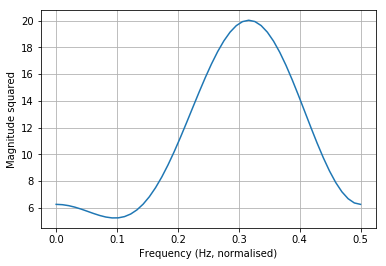

In [6]:
c = np.array([1, -2, 1.5, 2])

# Look at the frequency response of the filter up to the Nyquist frequency, and check it works properly
f = np.linspace(0, 0.5)
H = np.zeros(f.shape, dtype='complex128')
for k in range(4):
    H += c[k]*np.exp(k*1j*2*np.pi*f)

plt.plot(f, abs(H)**2)
plt.grid(True)
plt.xlabel('Frequency (Hz, normalised)')
plt.ylabel('Magnitude squared')


Looks legit, c.f. Fig 9 of paper

## Construct signal and noise sources
According to the Frost, "all signals were generated by a pseudo-Gaussian generator and filtered to give them proper spatial and temporal correlations. All temporal correlations were arranged to be identically zero for time differences greater than $25\tau$". 

I don't believe the paper gives all the information, e.g. the sensor spacing is not specified, and how this relates to the wavelengths of the incoming signals will be important. We'll need to make some assumptions about these things.

<table>
    <tr>
        <td>Source</td>
        <td>Power </td>
        <td>Direction (degrees, from normal)</td>
        <td>Center Frequency</td>
        <td>Bandwidth</td>
    </tr>
    <tr>
        <td>Signal</td>
        <td>0.1</td>
        <td>0</td>
        <td>0.3</td>
        <td>0.1</td>
    </tr>
        <tr>
        <td>Noise A</td>
        <td>1.0</td>
        <td>45</td>
        <td>0.2</td>
        <td>0.05</td>
    </tr>
    <tr>
        <td>Noise B</td>
        <td>1.0</td>
        <td>60</td>
        <td>0.4</td>
        <td>0.07</td>
    </tr>
</table>

In [8]:
def construct_signal(direction, bandwidth):
    

SyntaxError: invalid syntax (<ipython-input-8-aa6eeaaba8be>, line 1)